In [1]:
from datastructures.polycasebuilder import generate_random_polynomials
from testproblems import generate_random_prob

In [2]:
n_eqs = 6
n_vars = 8
seed = 2#8 is triang#seed 10 is nice 42
sparsity = 1.3#0.8 1.1 #1.7 1.3
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)
polynomials, var_mapping, edges, tree, components = generate_random_polynomials(eqv, dout, n_eqs)

In [3]:
from datastructures.graphutils import (edges_to_Ein_Eout, all_variables, all_components, dfs_tree, 
end_components, root_solver, solver_children)
import numpy as np
from datastructures.workflow import order_from_tree, ENDCOMP, COMP
from representations import plot_incidence_matrix
from collections import OrderedDict, defaultdict

In [19]:
import matplotlib.patches as patches

In [4]:
Ein, Eout = edges_to_Ein_Eout(edges)

In [5]:
Ein[4] = (2,4)
Eout[4] = (None,)

In [6]:
ntree = (
    OrderedDict([(0,1),(1,2),(2,1),(3,2),(4,1),(5,3)]),
    {1:3,2:3},
    {3:1}
     )

In [7]:
def sequence_permutation_from_order(order, Ein, Eout, Vtree, Ftree):
    Fend = end_components(Eout)
    sequence = [fx for _,fx,s in order]
    solvefor = Eout.copy() # assumes only one output
    f_at_level = {}
    for solvevar, solver in Vtree.items():
        if solver not in f_at_level:
            f_at_level[solver] = (elt for elt in solver_children(Ftree, solver) if elt in Fend)
        fend = next(f_at_level[solver])
        solvefor[fend] = (solvevar,)
    permutation = [solvefor[s][0] for s in sequence if solvefor.get(s, False) and solvefor[s][0] is not None]
    all_vars_random_order = all_variables(Ein, Eout)
    permutation += [var for var in all_vars_random_order if var not in permutation]
    return sequence, permutation

In [8]:
def all_comps_below(order, Stree, branch):
    applicable_solvers = dfs_tree(Stree, branch)
    allcomps = [(idx, end_or_inter==COMP) for idx, (end_or_inter, fx, solver) in enumerate(order) if solver in applicable_solvers]
    allcompsout, inter, end = tuple(), tuple(), tuple()
    for idx, inter_or_end in allcomps:
        elt = (idx, False)
        if inter_or_end:
            inter += (elt,)
        else:
            end += (elt,)
        allcompsout += (elt,)
    return allcompsout, inter, end

In [9]:
def solver_artifact_iterator(tree, order):
    _, Stree, _ = tree
    for branch in dfs_tree(Stree, root_solver(tree)):
        yield all_comps_below(order, Stree, branch)

In [29]:
def incidence_artifacts(edges, tree, generatesolverstruct=False):
    Ein, Eout = edges_to_Ein_Eout(edges)
    Ftree, Stree, Vtree = tree
    order = order_from_tree(Ftree, Stree, Eout, includesolver=False, mergeendcomp=False)
    sequence, permutation = sequence_permutation_from_order(order, Ein, Eout, Vtree, Ftree)
    solver_artifact = solver_artifact_iterator(tree, order) if generatesolverstruct else None
    return sequence, permutation, solver_artifact

In [30]:
def generate_incidence_matrix(Ein, Eout, sequence, permutation, diagonalgray=True):
    A = np.zeros((len(sequence), len(permutation)))
    for idx, fxid in enumerate(sequence):
        varsineq = Ein[fxid]+tuple(elt for elt in Eout[fxid] if elt is not None)
        for var in varsineq:
            col = permutation.index(var)
            color = 0.5 if (var in Eout[fxid] and diagonalgray) else 1.
            A[idx,col] = color
    return A

In [43]:
def render_incidence(edges, tree, namingfunc, displaysolver=True):
    sequence, permutation, solver_iterator = incidence_artifacts(edges, tree, displaysolver)
    A = generate_incidence_matrix(Ein, Eout, sequence, permutation)
    column_labels = ['${}$'.format(namingfunc(var, VAR).format(var)) for var in permutation]
    row_labels = ['${}$'.format(namingfunc(fx, COMP).format(fx)) for fx in sequence]
    fig, ax =plot_incidence_matrix(A, column_labels, row_labels)
    if displaysolver:
        allpatches=get_patches(solver_iterator)
        return plot_patches(ax, allpatches)

In [44]:
from datastructures.graphutils import namefromsympy, VAR, COMP, SOLVER, namefromid

In [45]:
nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: '{}'}
namingfunc = namefromid(nodetyperepr)

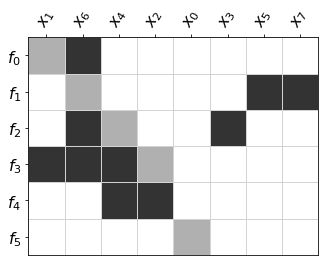

In [46]:
render_incidence(edges, tree, namingfunc, False)

In [12]:
sequence, permutation, solver_iterator = incidence_artifacts(edges, ntree)

In [13]:
A = generate_incidence_matrix(Ein, Eout, sequence, permutation)

In [14]:
column_labels = ['${}$'.format(namingfunc(var, VAR).format(var)) for var in permutation]
row_labels = ['${}$'.format(namingfunc(var, COMP).format(fx)) for fx in sequence]

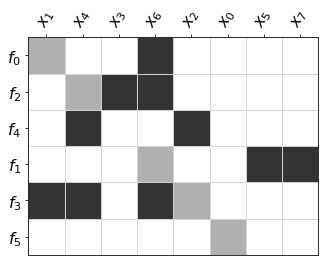

In [15]:
fig, ax =plot_incidence_matrix(A, column_labels, row_labels);

# Add groups

In [16]:
def getpatchwindow(lst):
    ulcorner = lst[0]
    size = max(lst)-ulcorner+1
    return ulcorner,size
def getpatchwindow_end(lst):
    equivalent_lst, matched_ends = zip(*lst)
    ulcorner,size = getpatchwindow(equivalent_lst)
    return ulcorner,size-sum(matched_ends)

In [17]:
def get_patches(solver_iterator):
    allpatches=[]
    for allcomps, inter, end in solver_iterator:
        patchparam = getpatchwindow_end(allcomps)
        patchparam_inter = [getpatchwindow_end(inter)] if inter else []
        patchparam_end = [getpatchwindow_end(end)] if end else []
        allpatches.append(patchparam)
        allpatches += patchparam_inter
        allpatches += patchparam_end
    return allpatches

In [18]:
def plot_patches(ax, allpatches):
    for ulcorner, size in allpatches:
        rect = patches.Rectangle((ulcorner,ulcorner), size, size, linewidth=2, edgecolor='k', facecolor='none')
        ax.add_patch(rect)

In [20]:
allpatches=get_patches(solver_iterator)

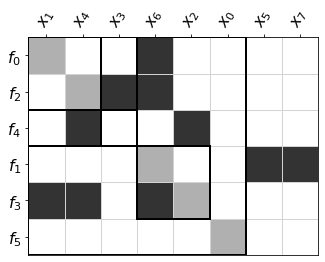

In [21]:
fig, ax =plot_incidence_matrix(A, column_labels, row_labels)
plot_patches(ax, allpatches)